# Regrid and smooth ACCESS-OM2 output as initial conditions for MOM6 panan + make temps near freezing point in the cavity.

Uses ACCESS-OM2-01 run year 2 that is close to initial conditions - see run and output here `/g/data/ol01/inputs/regional_boundary_forcing/access-om2-01/01deg_jra55v13_ryf9091/`

Modified from Wilton Aguiar


Is the T-S file from January? Or an average of the year2 ?

Created with an XX Large Mem ARE session with 100GB jobfs

In [1]:
#import cosima_cookbook as cc
#from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46135,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41495,Total threads: 4
Dashboard: /proxy/45553/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:43531,


In [2]:
ICs_ACCESSOM201 = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc')
ICs_ACCESSOM201_cold = ICs_ACCESSOM201.copy()

### linear freezing eqn of state

```
TFREEZE_FORM = "LINEAR"         ! default = "LINEAR"
                                ! TFREEZE_FORM determines which expression should be used for the freezing
                                ! point.  Currently, the valid choices are "LINEAR", "MILLERO_78", "TEOS_POLY",
                                ! "TEOS10"
TFREEZE_S0_P0 = 0.0             !   [degC] default = 0.0
                                ! When TFREEZE_FORM=LINEAR, this is the freezing potential temperature at S=0,
                                ! P=0.
DTFREEZE_DS = -0.054            !   [degC ppt-1] default = -0.054
                                ! When TFREEZE_FORM=LINEAR, this is the derivative of the freezing potential
                                ! temperature with salinity.
DTFREEZE_DP = -7.75E-08         !   [degC Pa-1] default = 0.0
                                ! When TFREEZE_FORM=LINEAR, this is the derivative of the freezing potential
                                ! temperature with pressure.
TFREEZE_S_IS_PRACS = True       !   [Boolean] default = True
                                ! When True, the model will check if the model internal salinity is practical
                                ! salinity.  If the model uses absolute salinity, a conversion will be applied.
TFREEZE_T_IS_POTT = True        !   [Boolean] default = True
                                ! When True, the model will check if the model internal temperature is potential
                                ! temperature.  If the model uses conservative temperature, a conversion will be
                                ! applied.

```

In [ ]:
# Let's start with everything in the cavities as freezing point + 0.05


In [5]:
surface = xr.open_dataset('/g/data/x77/cy8964/mom6/input/input-8km/surface_Charrassin_regridded.nc')
surface

<xarray.Dataset> Size: 190MB
Dimensions:    (ny: 3672, nx: 4320)
Dimensions without coordinates: ny, nx
Data variables:
    elevation  (ny, nx) float32 63MB ...
    lat        (ny, nx) float32 63MB ...
    lon        (ny, nx) float32 63MB ...
Attributes:
    description:  Surface elevation above sea level, float, 0 to 5000 meters....

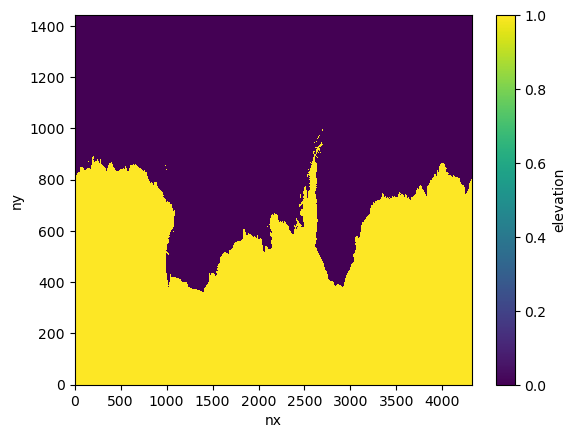

In [9]:
ice_shelf_mask = surface.elevation.isel(ny = np.arange(1442))
ice_shelf_mask = (ice_shelf_mask.where(ice_shelf_mask>0)*0+1).fillna(0)
ice_shelf_mask.plot()

In [11]:
ice_shelf_mask = ice_shelf_mask.rename({'nx':'nxp','ny':'nyp'})

In [12]:
Salt_in_cavity = ICs_ACCESSOM201_cold.salt.where(ice_shelf_mask>0)
depth_in_cavity = ICs_ACCESSOM201_cold.salt.where(ice_shelf_mask>0)*0+ICs_ACCESSOM201_cold.depth
TFREEZE_S0_P0 = 0
DTFREEZE_DS = -0.054 
DTFREEZE_DP = -7.75E-08

Freezing_point_in_cavity = TFREEZE_S0_P0 + DTFREEZE_DS*Salt_in_cavity + DTFREEZE_DP*depth_in_cavity*1035*9.80
Freezing_point_in_cavity

<xarray.DataArray (depth: 75, nyp: 1442, nxp: 4320)> Size: 4GB
array([[[-1.78977232, -1.78973339, -1.78969384, ..., -1.78982752,
         -1.78978883, -1.78975351],
        [-1.78977232, -1.78973339, -1.78969384, ..., -1.78982752,
         -1.78978883, -1.78975351],
        [-1.78977232, -1.78973339, -1.78969384, ..., -1.78982752,
         -1.78978883, -1.78975351],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79529752, -1.79525851, -1.79521889, ..., -1.79535283,
         -1.79531408, -1.7952787 ],
        [-1.79529752, -1.79525851, -1.79521889, ..., -1.79535283,
         -1.79531408, -1.7952787 ],
        [-1.79529752, -1.79525851, -1.79521889, ..., -1.79535283,
         -1.79531408, -1.7952787 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-6.33887524, -6.33886377, -6.33885392, ..., -6.338902  ,
         -6.33888247, -6.33886356],
        [-6.33887524, -6.33886377, -6.33885392, ..., -6.338902  ,
         -6.33888247, -6.33886356],
        [-6.33887524, -6.33886377, -6.33885392, ..., -6.338902  ,
         -6.33888247, -6.33886356],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5

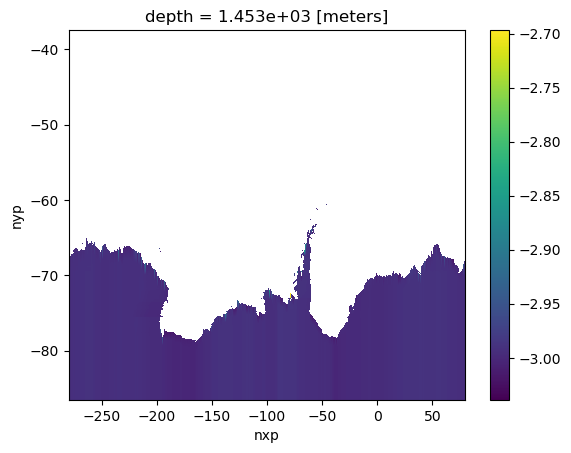

In [17]:
Freezing_point_in_cavity.isel(depth = 50).plot()

In [20]:
#combine them

ICs_ACCESSOM201_combined = ICs_ACCESSOM201_cold.copy()
ICs_ACCESSOM201_combined["temp"] = ICs_ACCESSOM201_cold.temp.where(ice_shelf_mask==0).fillna(0)+ \
                                (Freezing_point_in_cavity+0.1).fillna(0)
ICs_ACCESSOM201_combined

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nxp: 4320, nyp: 1442)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    salt     (depth, nyp, nxp) float64 4GB ...
    temp     (depth, nyp, nxp) float64 4GB -1.69 -1.69 -1.69 ... 1.135 1.135

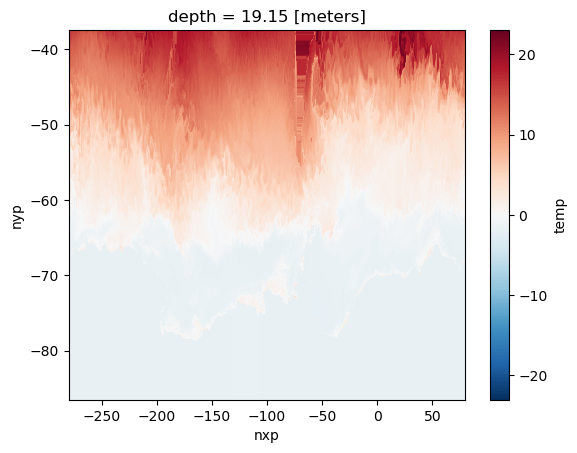

In [23]:
ICs_ACCESSOM201_combined.temp.isel(depth = 10).plot()

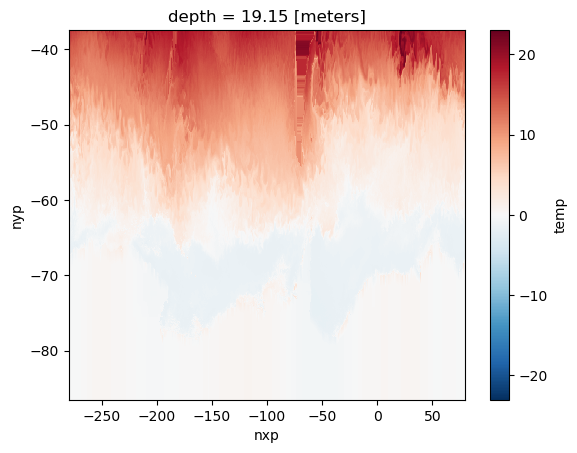

In [24]:
ICs_ACCESSOM201_cold.temp.isel(depth = 10).plot()

In [31]:
enc_TS = {
    "_FillValue": -1.e-20,
    # "zlib": True,
    # "shuffle": True,
    # "complevel": 1,
}

ICs_ACCESSOM201_combined.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland_01abovefreezingincavity.nc", encoding={"temp": enc_TS, "salt": enc_TS})


_____________________________________

Repeat for 0.01 degC

In [32]:
ICs_ACCESSOM201_combined = ICs_ACCESSOM201_cold.copy()
ICs_ACCESSOM201_combined["temp"] = ICs_ACCESSOM201_cold.temp.where(ice_shelf_mask==0).fillna(0)+ \
                                (Freezing_point_in_cavity+0.01).fillna(0)
ICs_ACCESSOM201_combined.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland_001abovefreezingincavity.nc", encoding={"temp": enc_TS, "salt": enc_TS})
